# Testing "GM hi"

Testing effect of GM in OM2-025 to increase mixing in high latitudes. If the test simulation looks promising, use new parameters in CM2-025. 

Below infos from Andy's email:

The MOM5 GM code is pretty confusing, with lots of options available. In general, these options can be used to do one of the following:
 1. scale the diffusivity coefficient everywhere by the same amount;
 2. vary the length scale in the diffusivity calculation
 3. vary the growth rate in the diffusivity calculation
 4. scale the diffusivity with grid size (effectively latitude)
 5. scale the diffusivity with depth.
 
From a quick look at the GM coefficient in an ocean only simulation I think the GM coefficient could be strengthened, especially towards the poles — see the first figure in [this notebook](https://github.com/AndyHoggANU/GMRediTesting/blob/master/TestingGM-Params.ipynb).
To do this, 2 and 5 above are no help at all, while 3 is complicated. For this reason, I decided to test out how far we could get with just 1 and 4, and the results of a few tests are shown if you scroll down the notebook. Hopefully it’s self-explanatory.
 
In short, I think we need to increase the coefficient while also increasing the scaling power, which means that Equatorial GM increases less than at the poles. My  instinct here is telling me that we should consider these options:

`agm_closure_scaling = 0.21`

`agm_closure_grid_scaling_power = 4.0`
 
which would just need to be added to the MOM namelist file. If we did that, we would get the purple line in the last two plots, which I think is OK. 
 
Having said that, before putting this into the coupled model, it might be worth testing in the ocean-only model. I could run a few different cases and compare things after 100 years or so?


Default values in `025deg_jra55_ryf9091_gadi` and CM2-025:

`agm_closure_scaling = 0.07`

`agm_closure_grid_scaling_power = 2.0 (default)`

Note that the OM2-025 RYF simulation has gm turned on but there's no output to calculate overturning (`ty_trans_gm`).

In [6]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import numpy as np
%matplotlib inline

# Stop annoying warnings coming out of xarray.
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42325,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:46205,Total threads: 2
Dashboard: /proxy/42967/status,Memory: 9.14 GiB
Nanny: tcp://127.0.0.1:39293,


In [3]:
# OM2 database
session_OM2  = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt_OM2_025_cntr = '025deg_jra55_ryf9091_gadi'

session_GMhi = cc.database.create_session('/g/data/x77/wgh581/access-om2-databases/025deg_jra55_ryf9091_GMhi.db')
expt_OM2_025_GMhi = '025deg_jra55_ryf9091_GMhi'

In [7]:
from cosima_cookbook import explore
dbx = explore.DatabaseExplorer(session=session_GMhi) # session=session
dbx

DatabaseExplorer(children=(HTML(value='<style>.header p{ line-height: 1.4; margin-bottom: 10px }</style>\n    …

In [8]:
# Plotting info
fig_path = '/g/data/x77/wgh581/Figures/Figures_ACCESS_CM2/'

ft_size = 16
plt.rcParams.update({'font.size': ft_size})

### Import data

In [9]:
# North Atlantic
lon_slice_NA = slice(-75,-7)
lat_slice_NA = slice(25,70)

# Southern Ocean (south of Africa)
lat_slice_SO = slice(-80,-34)

# Weddell Sea
lon_slice_WS = slice(-65,0)
lat_slice_WS = slice(-80,-63)

In [1]:
# For time span check start time of GMhi simulation

### SST

Global mean time series

In [10]:
def get_scalar_timeseries(expt, session, var, start_time='1900-01-01', end_time='1900-12-31', frequency='1 daily'):
    
    data = cc.querying.getvar(expt, var, session, start_time=start_time, end_time=end_time, frequency=frequency)
    data = data.sel(time=slice(start_time, end_time))#.resample(time='Y').mean()
    data = data.load()
    
    return data

In [11]:
SST_global_cntr = get_scalar_timeseries(expt_OM2_025_cntr, session_OM2, 'temp_surface_ave', start_time='1900-01-01', end_time='1976-12-31', frequency='1 monthly')
SST_global_GMhi = get_scalar_timeseries(expt_OM2_025_GMhi, session_GMhi, 'temp_surface_ave', start_time='1900-01-01', end_time='1976-12-31')

In [12]:
SST_global_cntr = SST_global_cntr.resample(time='Y').mean()
SST_global_GMhi = SST_global_GMhi.resample(time='Y').mean()

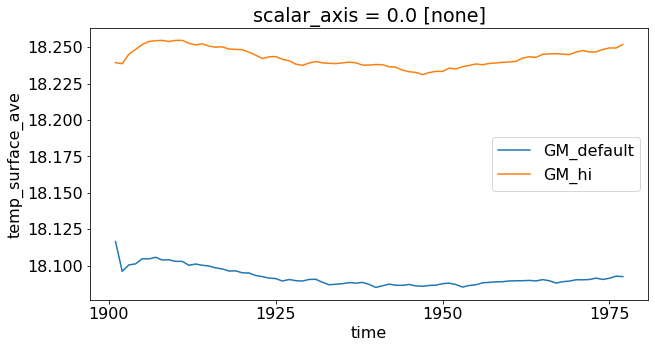

In [13]:
fig = plt.figure(figsize=(10,5))

SST_global_cntr.plot(label='GM_default')
SST_global_GMhi.plot(label='GM_hi')
plt.legend()

(Start/end spike comes from averaging.)

North Atlantic annual average

In [23]:
def get_SST_annual(expt, session, lon_slice, lat_slice, start_time='1900-01-01', end_time='1900-12-31', frequency='1 monthly'):

    data = cc.querying.getvar(expt, 'temp', session, start_time=start_time, end_time=end_time, frequency=frequency)
    data = data.sel(time=slice(start_time, end_time)).sel(st_ocean=0, method='nearest').sel(xt_ocean=lon_slice).sel(yt_ocean=lat_slice)   
    data = data.resample(time='Y').mean()
    
    return data.load()

In [15]:
SST_NA_cntr = get_SST_annual(expt_OM2_025_cntr, session_OM2, lon_slice_NA, lat_slice_NA, start_time='1900-01-01', end_time='1976-12-31')
SST_NA_GMhi = get_SST_annual(expt_OM2_025_GMhi, session_GMhi, lon_slice_NA, lat_slice_NA, start_time='1900-01-01', end_time='1976-12-31')

IndexError: index 25 is out of bounds for axis 0 with size 4

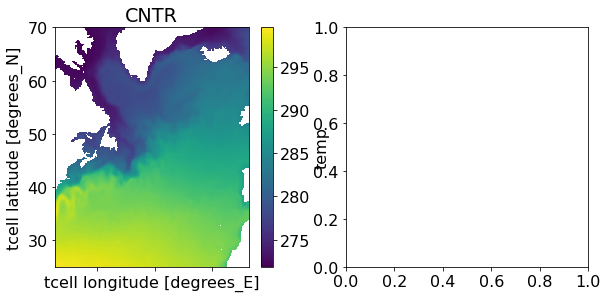

In [16]:
fig = plt.figure(figsize=(20,15))

years = [1, 25, 50, 75]

for ii in range(4):
    plt.subplot(3,4,ii+1)
    SST_NA_cntr[years[ii],...].plot()
    if ii == 0:
        plt.title('CNTR')
    else:
        plt.title('')
    plt.tick_params(labelbottom=False)
    
for ii in range(4):
    plt.subplot(3,4,ii+5)
    SST_NA_GMhi[years[ii],...].plot()
    if ii == 0:
        plt.title('GM hi')
    else:
        plt.title('')
        plt.tick_params(labelleft=False)
    plt.tick_params(labelbottom=False)
    
for ii in range(4):
    plt.subplot(3,4,ii+9)
    (SST_NA_cntr[years[ii],...]-SST_NA_GMhi[years[ii],...]).plot()
    if ii == 0:
        plt.title('CNTR - GM hi')
    else:
        plt.title('')

### MLD

In [ ]:
def get_mld_month(expt, session, lon_slice, lat_slice, month=3, start_time=start_time, end_time=end_time, frequency='1 monthly'):

    data = cc.querying.getvar(expt, 'mld', session, start_time=start_time, end_time=end_time, frequency=frequency)
    data = data.sel(time=slice(start_time, end_time)).sel(xt_ocean=lon_slice).sel(yt_ocean=lat_slice)   
    data = data.groupby('time.month')[month]
    
    return data.load()

In [ ]:
mld_NA_cntr = get_mld_month(expt_OM2_025_cntr, session_OM2, lon_slice_NA, lat_slice_NA, start_time='2200-01-01', end_time='2204-12-31')
mld_NA_GMhi = get_mld_month(expt_OM2_025_GMhi, session_OM2, lon_slice_NA, lat_slice_NA, start_time='2200-01-01', end_time='2204-12-31')

In [ ]:
mld_WS_cntr = get_mld_month(expt_OM2_025_cntr, session_OM2, lon_slice_WS, lat_slice_WS, start_time='2200-01-01', end_time='2204-12-31')
mld_WS_GMhi = get_mld_month(expt_OM2_025_GMhi, session_OM2, lon_slice_WS, lat_slice_WS, start_time='2200-01-01', end_time='2204-12-31')

In [ ]:
fig = pl.figure(figsize=(20,15))

for ii in range(4):
    plt.subplot(3,4,ii)
    mld_NA_cntr[ii,...].plot()
    if ii == 0:
        plt.title('CNTR')
    else:
        plt.title('')
    
for ii in range(4):
    plt.subplot(3,4,ii)
    mld_NA_GMhi[ii,...].plot()
    if ii == 0:
        plt.title('GM hi')
    else:
        plt.title('')
    
for ii in range(4):
    plt.subplot(3,4,ii)
    (mld_NA_cntr[ii,...]-mld_NA_GMhi[ii,...]).plot()
    if ii == 0:
        plt.title('CNTR - GM hi')
    else:
        plt.title('')

In [ ]:
fig = pl.figure(figsize=(20,15))

for ii in range(4):
    plt.subplot(3,4,ii)
    mld_WS_cntr[ii,...].plot()
    if ii == 0:
        plt.title('CNTR')
    else:
        plt.title('')
    
for ii in range(4):
    plt.subplot(3,4,ii)
    mld_WS_GMhi[ii,...].plot()
    if ii == 0:
        plt.title('GM hi')
    else:
        plt.title('')
    
for ii in range(4):
    plt.subplot(3,4,ii)
    (mld_WS_cntr[ii,...]-mld_NA_GMhi[ii,...]).plot()
    if ii == 0:
        plt.title('CNTR - GM hi')
    else:
        plt.title('')

### DP transport

In [19]:
straits = { 'DrakePassage': [-69.9, -69.9, -71.6, -51.0],
              'Lombok':     [-244.6, -243.9, -8.6, -8.6],
              'Ombai' :     [-235.0, -235.0, -9.2, -8.1],
              'Timor' :     [-235.9, -235.9, -11.9, -9.9],
              'Bering' :    [-172, -167, 65.8, 65.8],
              'Denmark' :   [-42, -22, 65.8, 65.8],
            }

In [20]:
rho = 1036 # kg/m^3, mean density of seawater

def calc_transport(expt, session, strait):
    """
    Calculate barotropic transport across a given 
     line of latitude or longitude.
     
    Designed for flow through straits.
    """
    
    xmin, xmax, ymin, ymax = straits[strait]
    
    if ymax>=65:
        raise ValueError('North of 65N the tripolar grid geometry brings complications and `.sum(''xt_ocean'')` is wrong!')
    
    print('Calculating {}: {} transport'.format(expt, strait))
    
    if xmin == xmax:       
        tx_trans = cc.querying.getvar(expt, 'tx_trans_int_z', session)
        transport = tx_trans.sel(xu_ocean=xmin, method='nearest')\
                            .sel(yt_ocean=slice(ymin, ymax))\
                            .sum('yt_ocean')/rho/1e6 #divide by ρ to convert to volume transport, m^3/s, and with 1e6 to convert to Sv.
  
    elif ymin == ymax:
        ty_trans = cc.querying.getvar(expt, 'ty_trans_int_z', session)
        transport = ty_trans.sel(yu_ocean=ymin, method='nearest')\
                            .sel(xt_ocean=slice(xmin, xmax))\
                            .sum('xt_ocean')/rho/1e6 #divide by ρ to convert to volume transport, m^3/s, and with 1e6 to convert to Sv.
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
    
    transport = transport.resample(time='Y').mean()
    transport = transport.compute()
       
    return transport

In [ ]:
DP_cntr = calc_transport(expt_OM2_025_cntr, session_OM2, 'DrakePassage')
DP_GMhi = calc_transport(expt_OM2_025_GMhi, session_GMhi, 'DrakePassage')

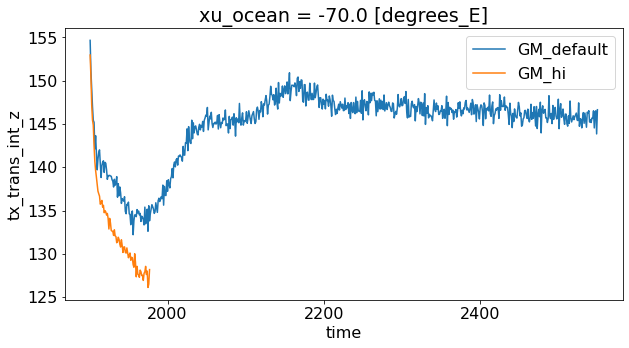

In [22]:
fig = plt.figure(figsize=(10,5))

DP_cntr.plot(label='GM_default')
DP_GMhi.plot(label='GM_hi')
plt.legend()

### uOHC